# Adhesive Plastic Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from SurfaceTopography import Topography, PlasticTopography, read_published_container
from ContactMechanics import FreeFFTElasticHalfSpace
from Adhesion.Interactions import Lj82
from Adhesion.System import make_system
from Adhesion.System import BoundedSmoothContactSystem
from ContactMechanics.Tools.Logger import screen, Logger

## Prepare Geometry

In [2]:
c, = read_published_container('https://contact.engineering/go/b9zfz')

In [3]:
[t.info["name"] for t in c ]

['randsurf.mat']

In [4]:
topography = c[0]

In [5]:
nx, ny = 512, 512 # number of gridpoints in x,y of AFM scans

In [6]:
sx,sy= 20, 20 # scan size in um

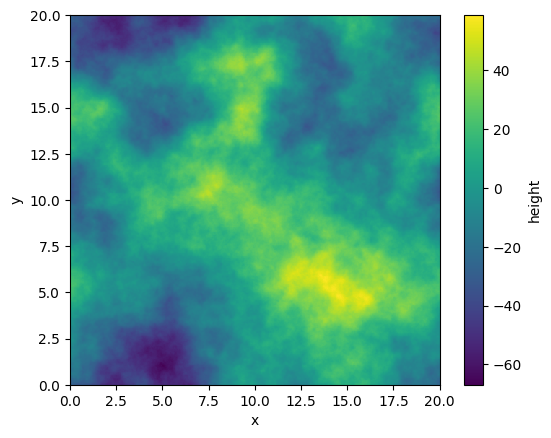

In [7]:
fig, ax = plt.subplots()
X, Y = np.meshgrid(np.arange(nx+1) * sx/nx, np.arange(ny+1) * sy/ny, indexing='ij') 
pcm = ax.pcolormesh(X,Y, topography.heights())
cb = plt.colorbar(pcm,ax= ax, label= "height")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)

Text(0, 0.5, 'heights ($z_0$)')

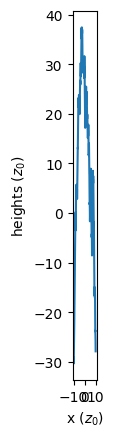

In [8]:
x = np.arange(0, nx).reshape(-1,1 ) * sx/nx - sx / 2
y = np.arange(0, ny).reshape(1,-1 ) * sy/ny - sy / 2
fig, ax = plt.subplots()
ax.plot(x, topography.heights()[:, ny//2])
ax.set_aspect(4.5)
ax.set_xlabel("x ($z_0$)")
ax.set_ylabel("heights ($z_0$)")

## Material Properties

In [42]:
Es = 0.01
z0 = 1. 
w = 1.

## setup system

In [43]:
system = make_system(
    interaction=Lj82(w, z0),
    substrate=FreeFFTElasticHalfSpace(
        nb_grid_pts=topography.nb_grid_pts, young=Es,
        physical_sizes=topography.physical_sizes,
        check_boundaries=False),
    surface=topography,
    system_class=BoundedSmoothContactSystem
           )

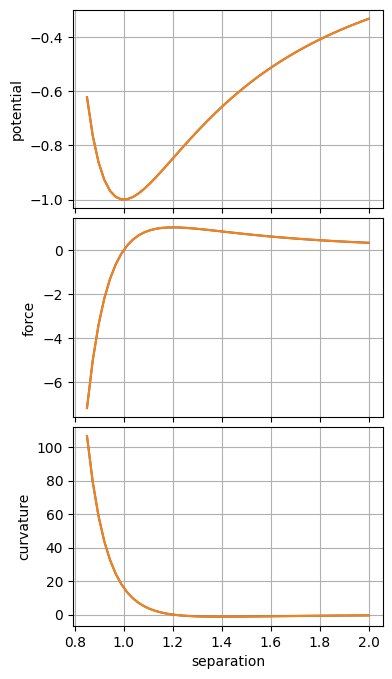

In [44]:
fig, ax = plt.subplots(3, sharex=True, figsize = (4,8))

z =np.linspace(0.85*z0,2*z0)
for poti in [Lj82(w, z0), system.interaction]:
    p,f,c = poti.evaluate(z, True, True, True)
    ax[0].plot(z,p)
    ax[1].plot(z,f)
    ax[2].plot(z,c)
    ax[0].set_ylabel("potential")
    ax[1].set_ylabel("force")
    ax[2].set_ylabel("curvature")
for a in ax:
    a.grid()
    
ax[2].set_xlabel("separation")
fig.subplots_adjust(hspace=0.05)

In [45]:
penetrations = np.linspace(-1, 2, 5)
#penetrations = np.concatenate((penetrations, penetrations[-2::-1])) #only needed for hysteresis tests

In [46]:
gtol = 1e-3

In [47]:
normal_forces = []
repulsive_areas = []
forces = np.zeros((len(penetrations), *topography.nb_grid_pts))
disp0=None
i=0
for penetration in penetrations:
    print(f"penetration = {penetration}")
    sol = system.minimize_proxy(                                                                                                                              
        options=dict(gtol=gtol, # max absolute value of the gradient of the objective for convergence 
                     ftol=0, # stop only if the gradient criterion is fullfilled
                     maxcor=3 # number of gradients stored for hessian approximation
                    ),                               
        logger=Logger("laststep.log"),                                 
        offset=penetration,                                           
        callback=None,                                                 
                )
    assert sol.success, sol.message
    disp0 = u = system.disp # TODO: the disp0 should only include the elastic displacements. u contains ela
    normal_forces.append(system.compute_normal_force())
    repulsive_areas.append(system.compute_repulsive_contact_area())
    forces[i,...] = - system.substrate.evaluate_force(u)[system.substrate.topography_subdomain_slices]
    i+=1

penetration = -1.0
penetration = -0.25
penetration = 0.5
penetration = 1.25
penetration = 2.0


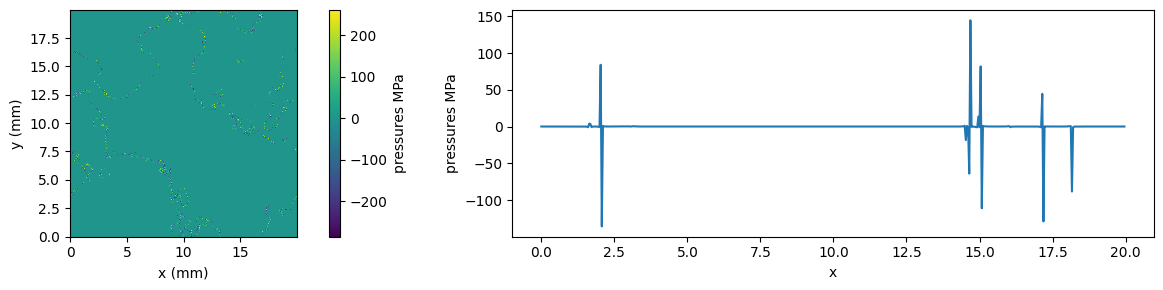

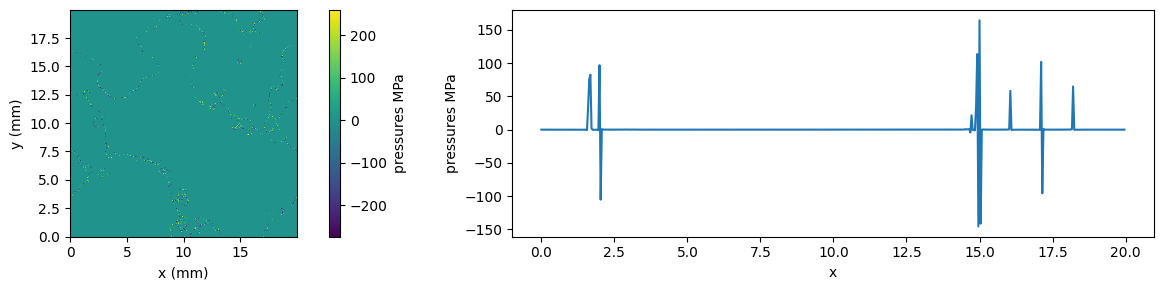

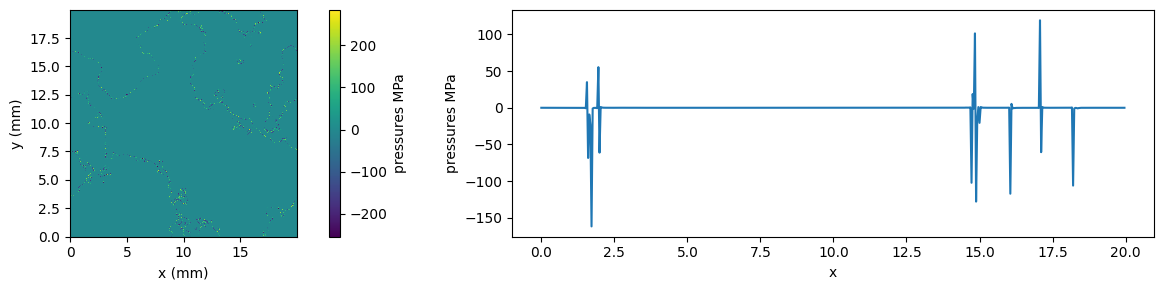

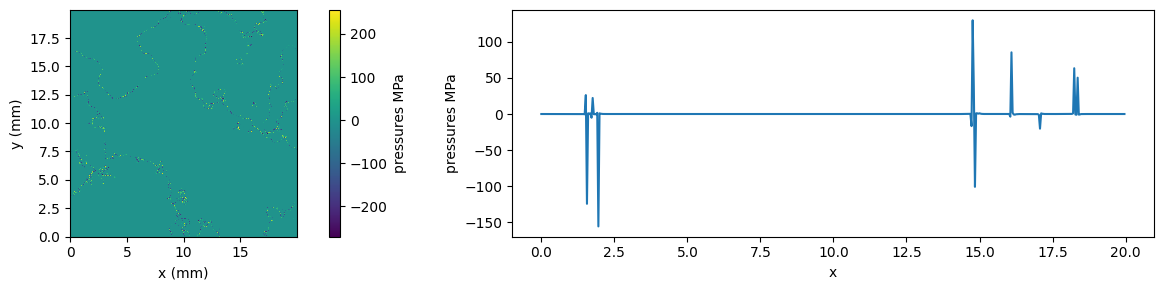

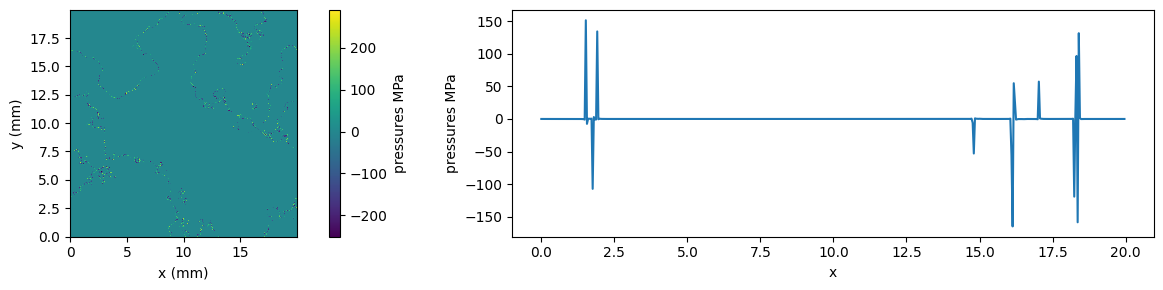

In [34]:
for i in range(len(penetrations)):
    
    fig, (axf, axfcut) = plt.subplots(1,2, figsize=(14,3))
    
    axf.set_xlabel("x (mm)")
    axf.set_ylabel("y (mm)")
        
    axfcut.plot(system.surface.positions()[0][:,0], forces[i, :, ny//2]/ system.area_per_pt)
    axfcut.set_xlabel("x")
    axfcut.set_ylabel("pressures MPa")
    
    
    
    plt.colorbar(axf.pcolormesh(*system.surface.positions(), forces[i,...]/ system.area_per_pt), label="pressures MPa", ax = axf)
    axf.set_aspect(1)
    
    
    
    fig.tight_layout()